...continue microoptimization 
V8 => 0.01367 

The following kernel here shows how the excellent kernel [here](https://www.kaggle.com/scirpus/hybrid-gp-and-nn) may benefit from adding some regularisation. Overfitting was suspected because the validation scores on the neural network were considerably below the public leaderboard score. [scirpus](https://www.kaggle.com/scirpus) produces a lot of high quality kernels for Kaggle so please be sure to upvote the kernel listed.

In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as mtr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)

In [2]:
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Dropout, PReLU, BatchNormalization, ELU, GaussianNoise, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nfl-big-data-bowl-2020/train.csv
/kaggle/input/nfl-big-data-bowl-2020/kaggle/competitions/nflrush/competition.cpython-36m-x86_64-linux-gnu.so
/kaggle/input/nfl-big-data-bowl-2020/kaggle/competitions/nflrush/test.csv.encrypted
/kaggle/input/nfl-big-data-bowl-2020/kaggle/competitions/nflrush/__init__.py
/kaggle/input/nfl-big-data-bowl-2020/kaggle/competitions/nflrush/sample_submission.csv.encrypted


In [4]:
train = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', usecols=['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis',
                                                                               'Orientation', 'Dir', 'NflId', 'DisplayName', 'YardLine',
                                                                               'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
                                                                               'FieldPosition', 'NflIdRusher', 'OffenseFormation', 
                                                                               'OffensePersonnel', 'DefendersInTheBox', 'DefensePersonnel', 
                                                                               'PlayDirection', 'TimeHandoff', 'TimeSnap', 'Yards',
                                                                              'WindSpeed', 'Temperature', 'Humidity'])

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

## Functions for anchoring offense moving left from {0,0}

In [6]:
def create_features(df, deploy=False):
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2

        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]

        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)

        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')

        return df
    
#     def wind_features(df):
#         df['WindSpeed'] = df['WindSpeed'].apply(lambda x: str(x).lower().replace('mph', '').strip() if not pd.isna(x) else x)
#         df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
#         df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
#         return df

    def projection_features(df):
        rad = 2 * np.pi * (90 - df[['Orientation']]) / 360
        v_0 = df['S'].values * np.cos(rad).values.reshape(-1)
        v_1 = np.sin(rad).values.reshape(-1)

        a_0 = df['A'].values * np.cos(rad).values.reshape(-1)
        a_1 = np.sin(rad)

        df['v_0'] = v_0
        df['v_1'] = v_1
        df['a_0'] = a_0
        df['a_1'] = a_1
        
        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]

        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']


        return defense

    def static_features(df):
        static_features = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                            'YardLine','Quarter','Down','Distance','DefendersInTheBox']].drop_duplicates()
        static_features['DefendersInTheBox'] = static_features['DefendersInTheBox'].fillna(np.mean(static_features['DefendersInTheBox']))

        return static_features


    def combine_features(relative_to_back, defense, static, speed_frame, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df, speed_frame, on=['GameId','PlayId'],how='inner')
        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df
    
#     df = wind_features(df)
    df = projection_features(df)
    speed_frame= df[['GameId','PlayId',
#                      'WindSpeed',
                     'a_0','a_1','v_0','v_1', 'Temperature', 'Humidity']]
    
    yardline = update_yardline(df)
    df = update_orientation(df, yardline)
    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    basetable = combine_features(rel_back, def_feats, static_feats,  speed_frame, deploy=deploy)
    basetable[['a_0','a_1','v_0','v_1']] = basetable[['a_0','a_1','v_0','v_1']].fillna(0)
    basetable['Temperature'] = basetable['Temperature'].fillna(60.436442)
    basetable['Humidity'] =     basetable['Humidity'].fillna(59.0)
    return basetable

In [7]:
# train['WindSpeed']

In [8]:
%time train_basetable = create_features(train, False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 2min 27s, sys: 1.76 s, total: 2min 28s
Wall time: 2min 27s


# Let's split our data into train/val

In [9]:
X = train_basetable.copy()
yards = X.Yards

y = np.zeros((yards.shape[0], 1))
_y =  np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx] = target#[99 + target] = 1
    _y[idx][99 + target] = 1

X.drop(['GameId','PlayId','Yards'], axis=1, inplace=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Let's build NN

Below class Metric based entirely on: https://www.kaggle.com/kingychiu/keras-nn-starter-crps-early-stopping
<br></br>
Below early stopping entirely based on: https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112868#latest-656533

In [10]:

def get_model(size=X.shape[1]):
    model = Sequential()
    model.add(GaussianNoise(0.05))
    model.add(BatchNormalization())
    model.add(Dense(256, input_dim=size, activation=None))
    model.add(ELU())
    model.add(GaussianNoise(0.05))
    model.add(Dropout(0.5)) #dropout is a type of regularisation. Regularisation helps to control overfitting
    model.add(BatchNormalization())
    model.add(Dense(256, activation=None))
    model.add(ELU())
    model.add(GaussianNoise(0.05))
#     model.add(Dropout(0.2))
     #dropout is a type of regularisation. Regularisation helps to control overfitting
    model.add(BatchNormalization())
    model.add(Dense(1, activation=None))
    model.compile(optimizer=Adam(lr=0.001), loss='mae')
   
    return model


def get_model_v2(size=X.shape[1]):
  
    model = Sequential()
    model.add(Dense(256, input_dim=size, activation=None))
    model.add(BatchNormalization())
    model.add(PReLU())
    model.add(Dropout(0.5)) #dropout is a type of regularisation. Regularisation helps to control overfitting
    model.add(Dense(256, activation=None))
    model.add(BatchNormalization())
    model.add(PReLU())
#     model.add(Dropout(0.2))
     #dropout is a type of regularisation. Regularisation helps to control overfitting
    model.add(BatchNormalization())
     #dropout is a type of regularisation. Regularisation helps to control overfitting
    model.add(Dense(199, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0005), loss='categorical_crossentropy', metrics=[])
   
    return model

In [11]:
from sklearn.model_selection import KFold, GroupKFold

In [12]:
models = []

oof_predictions = np.zeros(shape=(X.shape[0]))

rkf = GroupKFold(11)
FOLD_LIST = list(rkf.split(train_basetable['GameId'],train_basetable['GameId'],train_basetable['GameId']))

for fold_id, (tr_idx, vl_idx) in enumerate(FOLD_LIST):
    
    print(fold_id)

    x_tr, y_tr = X[tr_idx], y[tr_idx]
    x_vl, y_vl = X[vl_idx], y[vl_idx]    

    model= get_model(X.shape[1])
    es = EarlyStopping(monitor='val_loss', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=5)
#     es.set_model(model)

    model.fit(x_tr, y_tr, epochs=200, batch_size=1024, validation_data=[x_vl, y_vl], callbacks=[es])
    oof_predictions[vl_idx] += model.predict(x_vl).reshape(-1)
    models.append(model)


0
Train on 463628 samples, validate on 46134 samples
Epoch 1/200
463628/463628 [==============================] - 16s 35us/step - loss: 3.5837 - val_loss: 3.3790
Epoch 2/200
463628/463628 [==============================] - 15s 33us/step - loss: 3.3936 - val_loss: 3.3412
Epoch 3/200
463628/463628 [==============================] - 15s 33us/step - loss: 3.3651 - val_loss: 3.3533
Epoch 4/200
463628/463628 [==============================] - 15s 33us/step - loss: 3.3495 - val_loss: 3.3364
Epoch 5/200
463628/463628 [==============================] - 15s 33us/step - loss: 3.3380 - val_loss: 3.3255
Epoch 6/200
463628/463628 [==============================] - 15s 32us/step - loss: 3.3270 - val_loss: 3.3271
Epoch 7/200
463628/463628 [==============================] - 15s 32us/step - loss: 3.3186 - val_loss: 3.3284
Epoch 8/200
463628/463628 [==============================] - 15s 32us/step - loss: 3.3082 - val_loss: 3.3248
Epoch 9/200
463628/463628 [==============================] - 16s 34us/step 

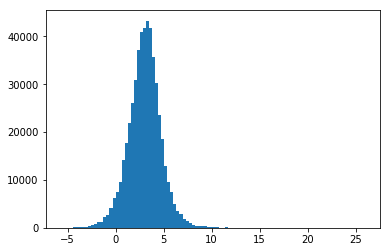

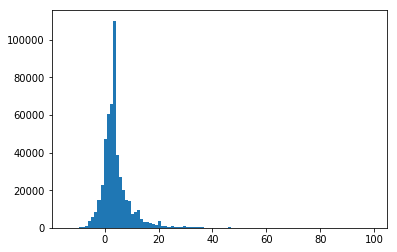

In [13]:
plt.figure()
plt.hist(oof_predictions, bins=100)
plt.show()

plt.figure()
plt.hist(y, bins=100)
plt.show()

In [14]:
from scipy.stats import spearmanr, pearsonr

In [15]:
print(
    pearsonr(y.reshape(-1), oof_predictions.reshape(-1)),
    spearmanr(y.reshape(-1), oof_predictions.reshape(-1))
)

(0.28604757207734266, 0.0) SpearmanrResult(correlation=0.41479075007941857, pvalue=0.0)


In [16]:
_X = np.hstack([X, oof_predictions.reshape(-1,1)])

In [17]:
X.shape, oof_predictions.shape, _X.shape

((509762, 29), (509762,), (509762, 30))

In [18]:
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        logs['tr_CRPS'] = 0

        X_valid, y_valid = self.data[1][0], self.data[1][1]

        y_pred = self.model.predict(X_valid)
        y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
        val_s = np.round(val_s, 6)
        logs['val_CRPS'] = val_s
        print('tr CRPS', 'Grr', 'val CRPS', val_s)

        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [19]:
_models = []
oof_predictions = np.zeros(shape=(_X.shape[0]))

for fold_id, (tr_idx, vl_idx) in enumerate(FOLD_LIST):
    
    print(fold_id)

    x_tr, y_tr = _X[tr_idx], _y[tr_idx]
    x_vl, y_vl = _X[vl_idx], _y[vl_idx]    

    model= get_model_v2(_X.shape[1])
    
    es = EarlyStopping(monitor='val_CRPS', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=3)
    es.set_model(model)
    
    metric = Metric(model, [es], [(x_tr, y_tr), (x_vl, y_vl)])
    model.fit(x_tr, y_tr, callbacks=[metric], epochs=5, batch_size=1024, validation_data=[x_vl, y_vl])

    _models.append(model)
    

0
Train on 463628 samples, validate on 46134 samples
Epoch 1/5
463628/463628 [==============================] - 19s 41us/step - loss: 3.5683 - val_loss: 2.7727
tr CRPS Grr val CRPS 0.012997
Epoch 2/5
463628/463628 [==============================] - 19s 40us/step - loss: 2.6983 - val_loss: 2.7305
tr CRPS Grr val CRPS 0.012857
Epoch 3/5
463628/463628 [==============================] - 18s 39us/step - loss: 2.6528 - val_loss: 2.7433
tr CRPS Grr val CRPS 0.012869
Epoch 4/5
463628/463628 [==============================] - 19s 40us/step - loss: 2.6169 - val_loss: 2.7632
tr CRPS Grr val CRPS 0.012898
Epoch 5/5
463628/463628 [==============================] - 18s 39us/step - loss: 2.5816 - val_loss: 2.7822
tr CRPS Grr val CRPS 0.012891
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping
1
Train on 463760 samples, validate on 46002 samples
Epoch 1/5
463760/463760 [==============================] - 19s 42us/step - loss: 3.5671 - val_loss: 2.8116
tr CRPS Grr val CRP

In [20]:
class GP:
    def __init__(self):
        self.classes = 20
        self.class_names = [ 'class_0',
                             'class_1',
                             'class_2',
                             'class_3',
                             'class_4',
                             'class_5',
                             'class_6',
                             'class_7',
                             'class_8',
                             'class_9',
                             'class_10',
                             'class_11',
                             'class_12',
                             'class_13',
                            'class_14',
                            'class_15',
                            'class_16',
                            'class_17',
                            'class_18',
                            'class_19',
                           ]


    def GrabPredictions(self, data):
        oof_preds = np.zeros((len(data), len(self.class_names)))
        oof_preds[:,0] = self.GP_class_0(data)
        oof_preds[:,1] = self.GP_class_1(data)
        oof_preds[:,2] = self.GP_class_2(data)
        oof_preds[:,3] = self.GP_class_3(data)
        oof_preds[:,4] = self.GP_class_4(data)
        oof_preds[:,5] = self.GP_class_5(data)
        oof_preds[:,6] = self.GP_class_6(data)
        oof_preds[:,7] = self.GP_class_7(data)
        oof_preds[:,8] = self.GP_class_8(data)
        oof_preds[:,9] = self.GP_class_9(data)
        oof_preds[:,10] = self.GP_class_10(data)
        oof_preds[:,11] = self.GP_class_11(data)
        oof_preds[:,12] = self.GP_class_12(data)
        oof_preds[:,13] = self.GP_class_13(data)
        oof_preds[:,14] = self.GP_class_14(data)
        oof_preds[:,15] = self.GP_class_15(data)
        oof_preds[:,16] = self.GP_class_16(data)
        oof_preds[:,17] = self.GP_class_17(data)
        oof_preds[:,18] = self.GP_class_18(data)
        oof_preds[:,19] = self.GP_class_19(data)
        oof_df = pd.DataFrame(np.exp(oof_preds), columns=self.class_names)
        oof_df =oof_df.div(oof_df.sum(axis=1), axis=0)
        
        return oof_df.values


    def GP_class_0(self,data):
        return(0.250000*np.tanh(((((((data[:,0]) - (((data[:,0]) + (data[:,0]))))) + (data[:,0]))) + (((((data[:,0]) * 2.0)) * 2.0)))) +
                0.250000*np.tanh(((((((((((((data[:,2]) - (data[:,7]))) * 2.0)) + (data[:,7]))) * 2.0)) + (data[:,0]))) + (((((data[:,2]) + (data[:,0]))) - (data[:,7]))))) +
                0.250000*np.tanh(((((((((((((((((((data[:,3]) - (data[:,7]))) - (((data[:,0]) / 2.0)))) + (data[:,0]))) - (data[:,7]))) + (data[:,2]))) + (((data[:,7]) + (data[:,2]))))) + (data[:,7]))) - (data[:,7]))) + (data[:,0]))) +
                0.250000*np.tanh(((((((((data[:,0]) - (data[:,7]))) - (data[:,14]))) + (((data[:,17]) - (data[:,14]))))) + (((((((data[:,0]) - ((1.0)))) - (data[:,0]))) + (data[:,20]))))) +
                0.250000*np.tanh(((((data[:,18]) + (((((((data[:,0]) - (data[:,7]))) + (data[:,2]))) + (data[:,0]))))) - (((data[:,7]) + (data[:,2]))))) +
                0.250000*np.tanh((((((((data[:,8]) + ((((((((data[:,13]) + (data[:,3]))) + (data[:,0]))/2.0)) + ((((((((data[:,0]) + (((((data[:,0]) - (data[:,0]))) / 2.0)))) + (data[:,17]))/2.0)) + (data[:,11]))))))/2.0)) + (data[:,0]))) - (data[:,13]))) +
                0.250000*np.tanh(((((data[:,0]) * 2.0)) + (((((((((data[:,2]) + (data[:,2]))) * 2.0)) - (((data[:,14]) - (((np.tanh((data[:,2]))) * 2.0)))))) - (data[:,7]))))) +
                0.250000*np.tanh(((((((((((((data[:,17]) - (((data[:,17]) * (((((data[:,17]) * (data[:,17]))) * 2.0)))))) + (((((((data[:,17]) * 2.0)) * 2.0)) * 2.0)))/2.0)) / 2.0)) + (((data[:,17]) - ((7.76236486434936523)))))/2.0)) + (((((((data[:,17]) * (data[:,17]))) * 2.0)) * 2.0)))) +
                0.250000*np.tanh(((((((((((data[:,17]) + (data[:,17]))/2.0)) + ((((data[:,17]) + ((((data[:,17]) + (data[:,17]))/2.0)))/2.0)))/2.0)) * (data[:,17]))) - (data[:,13]))) +
                0.250000*np.tanh((((((data[:,19]) + (((((((((data[:,19]) * 2.0)) + (data[:,19]))) - ((1.07645297050476074)))) + (((data[:,22]) + (data[:,22]))))))/2.0)) + (((data[:,22]) + (data[:,4]))))))
    
    def GP_class_1(self,data):
        return(0.250000*np.tanh(((((((((((((data[:,3]) + (((np.tanh((data[:,2]))) - (data[:,14]))))) - ((10.0)))) - ((4.88989353179931641)))) - ((13.92175483703613281)))) / 2.0)) - (data[:,6]))) +
                0.250000*np.tanh(data[:,3]) +
                0.250000*np.tanh(((data[:,2]) + (((((np.tanh((((data[:,14]) * 2.0)))) - (((((((data[:,7]) * 2.0)) - (((((data[:,0]) - (data[:,14]))) - (data[:,7]))))) - (data[:,0]))))) + (data[:,0]))))) +
                0.250000*np.tanh(((((((data[:,0]) - ((-1.0*((data[:,14])))))) + ((((((((((data[:,0]) - (data[:,7]))) - ((((data[:,14]) + (data[:,14]))/2.0)))) + (((data[:,2]) - (((data[:,0]) * (data[:,14]))))))/2.0)) - (data[:,14]))))) - (data[:,7]))) +
                0.250000*np.tanh(((((data[:,0]) / 2.0)) + (data[:,0]))) +
                0.250000*np.tanh(((((data[:,19]) - (data[:,19]))) / 2.0)) +
                0.250000*np.tanh(((((np.tanh((((np.tanh((data[:,5]))) - ((((1.69341480731964111)) + ((((((np.tanh((data[:,14]))) - (data[:,14]))) + (data[:,14]))/2.0)))))))) - (data[:,2]))) - (((data[:,14]) * 2.0)))) +
                0.250000*np.tanh((((((data[:,22]) + (((data[:,0]) + ((((((((data[:,22]) / 2.0)) + ((-1.0*((data[:,13])))))/2.0)) + (data[:,19]))))))/2.0)) - (data[:,13]))) +
                0.250000*np.tanh(((((((data[:,17]) / 2.0)) * (data[:,17]))) * (((data[:,17]) + (((data[:,17]) * (((((((((data[:,17]) + (data[:,17]))) * (data[:,17]))) * (data[:,17]))) + (((np.tanh((data[:,17]))) / 2.0)))))))))) +
                0.250000*np.tanh((((((data[:,14]) * (((data[:,13]) + (data[:,3]))))) + (((data[:,14]) * (((data[:,14]) - ((-1.0*((data[:,3])))))))))/2.0)))
    
    def GP_class_2(self,data):
        return(0.250000*np.tanh(((data[:,0]) + (np.tanh((((((((((data[:,2]) + (((data[:,2]) / 2.0)))/2.0)) + (data[:,0]))/2.0)) * (data[:,7]))))))) +
                0.250000*np.tanh((((data[:,22]) + (data[:,22]))/2.0)) +
                0.250000*np.tanh((((((data[:,14]) + ((-1.0*((((((4.73206138610839844)) + (((((((((((np.tanh((data[:,7]))) + (data[:,1]))/2.0)) - (np.tanh((((((data[:,0]) - (data[:,20]))) - (data[:,14]))))))) * ((7.0)))) + (data[:,14]))/2.0)))/2.0))))))/2.0)) - (data[:,14]))) +
                0.250000*np.tanh(((((data[:,1]) + ((4.15603733062744141)))) / 2.0)) +
                0.250000*np.tanh(((((((((((((data[:,0]) - (data[:,7]))) - (data[:,7]))) + ((((data[:,0]) + (data[:,0]))/2.0)))) * 2.0)) + (data[:,0]))) * 2.0)) +
                0.250000*np.tanh(((((data[:,11]) / 2.0)) / 2.0)) +
                0.250000*np.tanh(((((((((((((((((((((((data[:,2]) / 2.0)) + (((data[:,2]) / 2.0)))/2.0)) / 2.0)) / 2.0)) / 2.0)) + ((((-1.0*((((data[:,0]) / 2.0))))) * (((data[:,0]) / 2.0)))))/2.0)) + (data[:,0]))/2.0)) + (np.tanh((data[:,0]))))/2.0)) / 2.0)) +
                0.250000*np.tanh(((((data[:,0]) + (((data[:,0]) + (((((((data[:,14]) * (data[:,14]))) + (data[:,14]))) - (data[:,0]))))))) - (data[:,14]))) +
                0.250000*np.tanh((((((np.tanh((np.tanh(((0.0)))))) * (data[:,15]))) + (data[:,20]))/2.0)) +
                0.250000*np.tanh(((data[:,14]) * ((((data[:,13]) + ((((data[:,13]) + ((((data[:,14]) + ((((((data[:,14]) + ((((data[:,14]) + (((data[:,13]) - ((((-1.0*(((((data[:,14]) + (data[:,14]))/2.0))))) * 2.0)))))/2.0)))) + (data[:,14]))/2.0)))/2.0)))/2.0)))/2.0)))))
    
    def GP_class_3(self,data):
        return(0.250000*np.tanh(((((((((8.0)) + (((((((5.33416414260864258)) + ((9.0)))/2.0)) + ((((8.0)) * 2.0)))))) * 2.0)) + ((5.33416414260864258)))/2.0)) +
                0.250000*np.tanh((((9.48088836669921875)) + (((((10.56953334808349609)) + ((((4.48959350585937500)) + (np.tanh(((((3.0)) + ((9.0)))))))))/2.0)))) +
                0.250000*np.tanh((((((((((data[:,22]) / 2.0)) + (data[:,22]))/2.0)) * 2.0)) / 2.0)) +
                0.250000*np.tanh((10.44883441925048828)) +
                0.250000*np.tanh(((((data[:,0]) + (((data[:,0]) + ((-1.0*((data[:,9])))))))) + (((((data[:,0]) - (data[:,7]))) - (data[:,9]))))) +
                0.250000*np.tanh(((np.tanh((data[:,6]))) - (data[:,21]))) +
                0.250000*np.tanh(((data[:,0]) - (((((data[:,14]) + (((((data[:,14]) + (((data[:,14]) + (((data[:,14]) - (data[:,0]))))))) - (((((data[:,0]) - (data[:,14]))) + (data[:,14]))))))) - (((((data[:,14]) * (data[:,14]))) + (data[:,18]))))))) +
                0.250000*np.tanh(((data[:,14]) * ((((data[:,13]) + (data[:,14]))/2.0)))) +
                0.250000*np.tanh((((((data[:,8]) * (((data[:,8]) / 2.0)))) + ((((((data[:,9]) * (data[:,8]))) + (data[:,8]))/2.0)))/2.0)) +
                0.250000*np.tanh((((data[:,2]) + (((((((data[:,2]) + (data[:,20]))/2.0)) + ((((((((data[:,2]) + (data[:,8]))/2.0)) / 2.0)) - (data[:,8]))))/2.0)))/2.0)))
    
    def GP_class_4(self,data):
        return(0.250000*np.tanh((((12.98819637298583984)) / 2.0)) +
                0.250000*np.tanh(((((4.75780344009399414)) + (((((((8.66014671325683594)) + ((4.18107128143310547)))/2.0)) * ((8.97841739654541016)))))/2.0)) +
                0.250000*np.tanh((((9.0)) / 2.0)) +
                0.250000*np.tanh(((((((((((10.0)) + (np.tanh((((((6.0)) + ((((13.80149555206298828)) + ((7.0)))))/2.0)))))) + ((10.0)))) + (((((((data[:,0]) + ((8.0)))) / 2.0)) / 2.0)))/2.0)) + ((((-1.0*((((data[:,2]) * (data[:,9])))))) * 2.0)))) +
                0.250000*np.tanh(((((data[:,0]) + (((((((data[:,22]) + (data[:,22]))/2.0)) + (data[:,22]))/2.0)))) + ((((((data[:,22]) + ((((((data[:,22]) * 2.0)) + (data[:,22]))/2.0)))) + (data[:,18]))/2.0)))) +
                0.250000*np.tanh(((((((((((((np.tanh((data[:,18]))) + ((((data[:,1]) + (data[:,18]))/2.0)))/2.0)) * (data[:,18]))) * (data[:,18]))) + (((data[:,18]) * (data[:,18]))))/2.0)) - (((((((np.tanh((data[:,18]))) + (((data[:,18]) * (data[:,18]))))/2.0)) + (data[:,17]))/2.0)))) +
                0.250000*np.tanh(((np.tanh(((((((np.tanh((data[:,6]))) - (((np.tanh((data[:,6]))) - (data[:,6]))))) + (np.tanh((data[:,6]))))/2.0)))) - ((((data[:,10]) + ((((data[:,2]) + (((np.tanh((data[:,6]))) - (((np.tanh((np.tanh((data[:,6]))))) - (data[:,10]))))))/2.0)))/2.0)))) +
                0.250000*np.tanh((((((((((((data[:,10]) + (data[:,4]))) + (((data[:,10]) + (((data[:,0]) * (data[:,10]))))))/2.0)) + (((data[:,4]) * (((data[:,10]) + (data[:,4]))))))/2.0)) + (data[:,7]))/2.0)) +
                0.250000*np.tanh((((((data[:,11]) + (((((data[:,18]) / 2.0)) * (((data[:,11]) * (data[:,18]))))))/2.0)) * (((data[:,18]) * (((((((((data[:,18]) * (((((((data[:,11]) / 2.0)) / 2.0)) * (data[:,18]))))) / 2.0)) / 2.0)) * ((-1.0*((data[:,21])))))))))) +
                0.250000*np.tanh((((-1.0*((((((((((((data[:,2]) - (data[:,2]))) * (np.tanh((data[:,2]))))) + (np.tanh((((data[:,14]) * 2.0)))))/2.0)) + (data[:,2]))/2.0))))) - (data[:,2]))))
    
    def GP_class_5(self,data):
        return(0.250000*np.tanh(((((((((((3.46574378013610840)) + ((((np.tanh(((3.46574378013610840)))) + ((8.46705245971679688)))/2.0)))/2.0)) * 2.0)) + ((((3.46574378013610840)) + ((4.0)))))) + ((((4.0)) * 2.0)))) +
                0.250000*np.tanh((((10.55856513977050781)) / 2.0)) +
                0.250000*np.tanh((((3.76695251464843750)) / 2.0)) +
                0.250000*np.tanh((((((6.0)) / 2.0)) + ((((8.57984828948974609)) * 2.0)))) +
                0.250000*np.tanh((((((((((((3.42168045043945312)) + (data[:,7]))) + (np.tanh((data[:,7]))))) + (np.tanh((np.tanh((np.tanh(((3.42168045043945312)))))))))/2.0)) + (data[:,7]))/2.0)) +
                0.250000*np.tanh(((((((((((data[:,6]) - (data[:,9]))) + (data[:,7]))/2.0)) * 2.0)) + ((((((data[:,7]) + (data[:,9]))/2.0)) - (data[:,9]))))/2.0)) +
                0.250000*np.tanh(((((((((((data[:,22]) + (data[:,22]))) + (data[:,11]))/2.0)) + (data[:,22]))/2.0)) / 2.0)) +
                0.250000*np.tanh((((((((((0.76044219732284546)) / 2.0)) + ((0.76044219732284546)))/2.0)) + (np.tanh((np.tanh((((((((0.76043862104415894)) / 2.0)) + ((1.0)))/2.0)))))))/2.0)) +
                0.250000*np.tanh(((((((data[:,12]) + (np.tanh((data[:,9]))))/2.0)) + (((((((((((data[:,12]) + (((((0.0)) + (np.tanh((((((((data[:,7]) + (data[:,6]))/2.0)) + (data[:,7]))/2.0)))))/2.0)))/2.0)) / 2.0)) / 2.0)) + (data[:,7]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((((data[:,20]) / 2.0)) / 2.0)) * (((np.tanh((data[:,20]))) * (((data[:,20]) / 2.0)))))) * ((((((data[:,20]) / 2.0)) + (((data[:,20]) / 2.0)))/2.0)))))
    
    def GP_class_6(self,data):
        return(0.250000*np.tanh(((((((11.68076229095458984)) + (((((11.68075847625732422)) + ((((11.47270107269287109)) + (((((11.47269725799560547)) + ((11.68076229095458984)))/2.0)))))/2.0)))/2.0)) + ((((4.0)) * 2.0)))) +
                0.250000*np.tanh((((8.0)) + ((((10.0)) + ((6.59042119979858398)))))) +
                0.250000*np.tanh(((((((((((13.33760547637939453)) + (((((3.86388397216796875)) + (((((((8.18321037292480469)) + (data[:,4]))) + (((((((5.95386552810668945)) + ((12.93883609771728516)))) + (((((10.73907089233398438)) + ((4.0)))/2.0)))/2.0)))/2.0)))/2.0)))/2.0)) + (np.tanh(((3.0)))))) - ((2.0)))) + (((((10.61559963226318359)) + (data[:,1]))/2.0)))) +
                0.250000*np.tanh(((np.tanh(((((((((((7.13513946533203125)) + ((12.48778533935546875)))/2.0)) + (((((((7.13513565063476562)) - ((8.12031841278076172)))) + (((((((((7.13513565063476562)) + ((((10.69830417633056641)) + ((10.69830799102783203)))))) + ((10.69830799102783203)))) + ((7.83078956604003906)))/2.0)))/2.0)))/2.0)) * 2.0)))) + ((3.0)))) +
                0.250000*np.tanh(((((((((((data[:,7]) - (data[:,0]))) * 2.0)) - (data[:,7]))) + (data[:,7]))) + (data[:,0]))) +
                0.250000*np.tanh(((((data[:,7]) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((((((((((((((1.0)) + (((((((data[:,2]) + (((((((1.0)) * (data[:,2]))) + (data[:,14]))/2.0)))/2.0)) + ((1.0)))/2.0)))) + ((((1.0)) - (((data[:,2]) * (data[:,14]))))))/2.0)) - (data[:,2]))) * 2.0)) + (data[:,14]))/2.0)) + (data[:,14]))) +
                0.250000*np.tanh(((np.tanh((np.tanh(((((((data[:,19]) * ((0.0)))) + ((0.0)))/2.0)))))) / 2.0)) +
                0.250000*np.tanh((((((((0.0)) / 2.0)) / 2.0)) * (((((((((data[:,15]) / 2.0)) * ((0.0)))) / 2.0)) * ((((-1.0*(((0.0))))) / 2.0)))))) +
                0.250000*np.tanh(((((data[:,15]) * (((((((((((((np.tanh(((((0.09032609313726425)) / 2.0)))) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)))) / 2.0)))
    
    def GP_class_7(self,data):
        return(0.250000*np.tanh((10.27210903167724609)) +
                0.250000*np.tanh((((((((((10.0)) + (((((((((8.26972770690917969)) + ((11.06334972381591797)))/2.0)) * 2.0)) / 2.0)))) + ((((((5.0)) + ((((5.0)) + ((7.92727756500244141)))))) * 2.0)))) * ((7.92728137969970703)))) + ((10.0)))) +
                0.250000*np.tanh((8.42519950866699219)) +
                0.250000*np.tanh(((((((data[:,14]) + (data[:,14]))) + ((((((1.59392631053924561)) + (data[:,14]))) + (data[:,14]))))) + (np.tanh((((((data[:,14]) + (((((((3.0)) + (((data[:,14]) * 2.0)))/2.0)) + ((1.59391915798187256)))))) + ((1.59392631053924561)))))))) +
                0.250000*np.tanh((((data[:,7]) + (((data[:,0]) + (((((((data[:,7]) + (data[:,4]))/2.0)) + (((data[:,7]) * 2.0)))/2.0)))))/2.0)) +
                0.250000*np.tanh((((((((((((((data[:,9]) - (((data[:,0]) - (data[:,0]))))) - (((data[:,0]) / 2.0)))) / 2.0)) - (((data[:,21]) - (data[:,7]))))) + (data[:,21]))/2.0)) - (data[:,0]))) +
                0.250000*np.tanh((((((((((2.0)) + ((((((data[:,21]) + ((((data[:,13]) + (((((((((((data[:,13]) * 2.0)) + (data[:,21]))/2.0)) + (data[:,13]))/2.0)) * 2.0)))/2.0)))/2.0)) - (np.tanh(((((0.0)) - (data[:,21]))))))))) + ((1.0)))/2.0)) + (data[:,13]))/2.0)) +
                0.250000*np.tanh(((((data[:,14]) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((((((((((((((-1.0*(((((((data[:,21]) / 2.0)) + (data[:,8]))/2.0))))) / 2.0)) / 2.0)) / 2.0)) + (data[:,9]))/2.0)) / 2.0)) + ((((((((((((data[:,7]) / 2.0)) / 2.0)) / 2.0)) / 2.0)) + (data[:,7]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((np.tanh(((1.0)))) / 2.0)) / 2.0)) / 2.0)))
    
    def GP_class_8(self,data):
        return(0.250000*np.tanh(((((((data[:,0]) + (((((6.71804094314575195)) + (data[:,15]))/2.0)))) + ((((((11.56385326385498047)) * 2.0)) * ((((10.48986148834228516)) + ((11.56385326385498047)))))))) / 2.0)) +
                0.250000*np.tanh((((((((((data[:,14]) / 2.0)) + ((2.83755254745483398)))/2.0)) + ((((((data[:,12]) + (data[:,14]))/2.0)) + (data[:,14]))))) + ((((data[:,9]) + (((data[:,12]) + (data[:,14]))))/2.0)))) +
                0.250000*np.tanh(((((((((data[:,6]) + (((((((3.50821948051452637)) + ((((data[:,21]) + ((11.92932796478271484)))/2.0)))) + ((1.0)))/2.0)))) + (data[:,10]))/2.0)) + (data[:,21]))/2.0)) +
                0.250000*np.tanh(((data[:,14]) + (np.tanh((np.tanh(((-1.0*((((data[:,22]) - (data[:,13])))))))))))) +
                0.250000*np.tanh(((((1.0)) + ((((data[:,7]) + (data[:,7]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((((data[:,21]) / 2.0)) / 2.0)) * (((((((np.tanh((((np.tanh((data[:,13]))) / 2.0)))) / 2.0)) + (((((((np.tanh(((((data[:,21]) + (data[:,21]))/2.0)))) / 2.0)) - (data[:,12]))) / 2.0)))) / 2.0)))) - (data[:,12]))) +
                0.250000*np.tanh((((data[:,7]) + (np.tanh(((((data[:,12]) + (((data[:,7]) * ((((data[:,13]) + (data[:,13]))/2.0)))))/2.0)))))/2.0)) +
                0.250000*np.tanh(((((((data[:,13]) / 2.0)) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((((((((np.tanh((data[:,9]))) + (data[:,13]))/2.0)) + ((((((((data[:,21]) / 2.0)) * 2.0)) + ((((3.94983267784118652)) / 2.0)))/2.0)))/2.0)) + ((((np.tanh(((3.94983267784118652)))) + (data[:,9]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((((((((((data[:,14]) * (((((((((data[:,19]) / 2.0)) * (np.tanh((((data[:,2]) / 2.0)))))) / 2.0)) / 2.0)))) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) * (((((data[:,11]) / 2.0)) / 2.0)))))
    
    def GP_class_9(self,data):
        return(0.250000*np.tanh(((((((data[:,14]) * 2.0)) / 2.0)) + (((((data[:,14]) + (np.tanh((((data[:,14]) * 2.0)))))) + (data[:,14]))))) +
                0.250000*np.tanh(((data[:,9]) - (((((-1.0*((data[:,11])))) + (data[:,9]))/2.0)))) +
                0.250000*np.tanh(((data[:,21]) * 2.0)) +
                0.250000*np.tanh((((((data[:,14]) + (data[:,14]))/2.0)) + ((((data[:,13]) + ((((np.tanh((((data[:,9]) + ((6.0)))))) + (data[:,9]))/2.0)))/2.0)))) +
                0.250000*np.tanh(np.tanh(((1.0)))) +
                0.250000*np.tanh(((np.tanh((np.tanh(((((np.tanh((((data[:,20]) * (((((((np.tanh((((data[:,20]) / 2.0)))) + (data[:,12]))/2.0)) + ((((data[:,15]) + ((((data[:,17]) + (data[:,9]))/2.0)))/2.0)))/2.0)))))) + (data[:,9]))/2.0)))))) / 2.0)) +
                0.250000*np.tanh(((((data[:,2]) - (data[:,11]))) / 2.0)) +
                0.250000*np.tanh((((((((data[:,13]) / 2.0)) + (((data[:,7]) + (data[:,7]))))/2.0)) - (((((data[:,22]) + (((((data[:,14]) * (((((data[:,7]) * (((data[:,13]) - ((((data[:,7]) + (((((data[:,13]) / 2.0)) + (data[:,7]))))/2.0)))))) / 2.0)))) * 2.0)))) / 2.0)))) +
                0.250000*np.tanh(((((((((((((((data[:,1]) / 2.0)) + ((1.0)))/2.0)) + ((1.0)))/2.0)) + ((((((((((1.0)) / 2.0)) + (np.tanh(((1.0)))))/2.0)) + (np.tanh((((((1.0)) + ((1.0)))/2.0)))))/2.0)))/2.0)) + ((((data[:,20]) + ((1.0)))/2.0)))/2.0)) +
                0.250000*np.tanh(((data[:,1]) * ((((data[:,14]) + (np.tanh(((((0.0)) / 2.0)))))/2.0)))))
    
    def GP_class_10(self,data):
        return(0.250000*np.tanh((((((((((data[:,2]) + (((data[:,9]) * (np.tanh((data[:,14]))))))/2.0)) + ((((((data[:,14]) + (data[:,20]))/2.0)) + (data[:,0]))))/2.0)) + (data[:,14]))/2.0)) +
                0.250000*np.tanh((((((data[:,9]) + ((-1.0*((((((((2.04309988021850586)) + (((data[:,11]) + (((np.tanh((data[:,0]))) / 2.0)))))/2.0)) * 2.0))))))/2.0)) + (data[:,2]))) +
                0.250000*np.tanh(data[:,21]) +
                0.250000*np.tanh((((((((data[:,14]) + (np.tanh((((data[:,6]) / 2.0)))))/2.0)) + (data[:,14]))) + (((((data[:,14]) * 2.0)) + ((((data[:,13]) + (data[:,14]))/2.0)))))) +
                0.250000*np.tanh(data[:,9]) +
                0.250000*np.tanh(((((((data[:,15]) * 2.0)) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((((((2.72836518287658691)) * ((((1.0)) / 2.0)))) / 2.0)) / 2.0)) +
                0.250000*np.tanh(((((np.tanh((((data[:,7]) + (np.tanh(((((((((((0.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)))))))) / 2.0)) / 2.0)) +
                0.250000*np.tanh(np.tanh((((np.tanh(((11.43236827850341797)))) / 2.0)))) +
                0.250000*np.tanh(np.tanh((((data[:,7]) / 2.0)))))
    
    def GP_class_11(self,data):
        return(0.250000*np.tanh((-1.0*((((((((((((((data[:,5]) - (((data[:,9]) - ((((-1.0*(((11.40053558349609375))))) / 2.0)))))) + ((((11.40053558349609375)) + ((((11.40053558349609375)) * 2.0)))))) / 2.0)) - (data[:,7]))) - ((-1.0*(((11.40053939819335938))))))) * 2.0))))) +
                0.250000*np.tanh(((((data[:,14]) * 2.0)) + (data[:,14]))) +
                0.250000*np.tanh(((data[:,2]) + (((((data[:,5]) + (data[:,3]))) + ((((data[:,2]) + (((data[:,3]) * 2.0)))/2.0)))))) +
                0.250000*np.tanh(((((((((((data[:,21]) + (data[:,21]))) + ((-1.0*(((((np.tanh((np.tanh((((data[:,14]) / 2.0)))))) + (data[:,21]))/2.0))))))/2.0)) * 2.0)) + ((((data[:,14]) + (data[:,3]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((data[:,0]) + ((((data[:,9]) + ((((data[:,9]) + (((((((((((((((data[:,9]) / 2.0)) - (data[:,10]))) + (data[:,5]))/2.0)) - (data[:,9]))) + (data[:,9]))/2.0)) / 2.0)))/2.0)))/2.0)))/2.0)) + (data[:,9]))/2.0)) +
                0.250000*np.tanh((((((((data[:,13]) + ((((data[:,13]) + (data[:,13]))/2.0)))) + (data[:,1]))/2.0)) / 2.0)) +
                0.250000*np.tanh(data[:,14]) +
                0.250000*np.tanh(((((data[:,2]) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((data[:,9]) + (data[:,9]))/2.0)) +
                0.250000*np.tanh(data[:,2]))
    
    def GP_class_12(self,data):
        return(0.250000*np.tanh((((((((-1.0*((data[:,18])))) - (np.tanh((data[:,9]))))) + ((8.0)))) - ((14.74865913391113281)))) +
                0.250000*np.tanh((((((data[:,21]) + (np.tanh((data[:,9]))))) + ((((((((data[:,5]) / 2.0)) * 2.0)) + (data[:,5]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((data[:,14]) + (data[:,14]))) + (((data[:,14]) * 2.0)))) +
                0.250000*np.tanh(((data[:,2]) + (((((((data[:,14]) + ((((np.tanh((data[:,10]))) + (data[:,17]))/2.0)))/2.0)) + (data[:,21]))/2.0)))) +
                0.250000*np.tanh((((data[:,9]) + ((((((((((((data[:,9]) + ((((((data[:,9]) / 2.0)) + (((data[:,9]) * 2.0)))/2.0)))/2.0)) + ((-1.0*((data[:,21])))))/2.0)) * (data[:,9]))) + (((((np.tanh((((data[:,21]) / 2.0)))) / 2.0)) / 2.0)))/2.0)))/2.0)) +
                0.250000*np.tanh(((((0.0)) + (data[:,13]))/2.0)) +
                0.250000*np.tanh((((((((data[:,2]) / 2.0)) * 2.0)) + (data[:,7]))/2.0)) +
                0.250000*np.tanh((((((data[:,14]) * 2.0)) + (np.tanh((data[:,14]))))/2.0)) +
                0.250000*np.tanh(np.tanh((((((((((-1.0*((((np.tanh((data[:,9]))) / 2.0))))) / 2.0)) / 2.0)) + (((data[:,3]) * (data[:,13]))))/2.0)))) +
                0.250000*np.tanh((-1.0*((((((((-1.0*(((((((-1.0*((data[:,18])))) - ((((0.0)) / 2.0)))) / 2.0))))) + (np.tanh(((((-1.0*(((-1.0*((data[:,22]))))))) / 2.0)))))/2.0)) / 2.0))))))
    
    def GP_class_13(self,data):
        return(0.250000*np.tanh(((((np.tanh((np.tanh((data[:,2]))))) - ((10.0)))) - (np.tanh((((((data[:,7]) - ((((((6.0)) - ((4.87243366241455078)))) - ((9.0)))))) - ((14.80352973937988281)))))))) +
                0.250000*np.tanh(((np.tanh((((((3.0)) + (data[:,1]))/2.0)))) - ((7.0)))) +
                0.250000*np.tanh(((((np.tanh((np.tanh((np.tanh((data[:,6]))))))) * 2.0)) - ((6.10337877273559570)))) +
                0.250000*np.tanh(((((((data[:,9]) + (data[:,14]))) + (data[:,14]))) + (data[:,14]))) +
                0.250000*np.tanh(((((((np.tanh(((((-1.0*(((((((data[:,2]) + ((10.0)))/2.0)) / 2.0))))) - ((13.28130435943603516)))))) + ((10.0)))) - ((13.28130435943603516)))) + ((-1.0*((data[:,5])))))) +
                0.250000*np.tanh(((((((((((data[:,20]) + (((((((((data[:,20]) * 2.0)) * 2.0)) * 2.0)) + (data[:,13]))))/2.0)) + (((data[:,9]) + (((data[:,9]) + (((data[:,6]) + (data[:,9]))))))))/2.0)) + (data[:,20]))) + (data[:,15]))) +
                0.250000*np.tanh(((((((((data[:,14]) / 2.0)) + ((((data[:,9]) + (((data[:,15]) + (((data[:,5]) + ((((((data[:,9]) + (((data[:,5]) + (data[:,14]))))) + (data[:,9]))/2.0)))))))/2.0)))) * 2.0)) + (data[:,14]))) +
                0.250000*np.tanh((((data[:,13]) + (data[:,7]))/2.0)) +
                0.250000*np.tanh(((data[:,9]) + ((((data[:,3]) + ((((data[:,21]) + (data[:,3]))/2.0)))/2.0)))) +
                0.250000*np.tanh((((data[:,2]) + (((((((((((((((data[:,20]) + (data[:,1]))) + (((data[:,2]) + (data[:,14]))))) + (data[:,2]))) + (np.tanh((data[:,2]))))/2.0)) + (((data[:,14]) + (data[:,2]))))) + (data[:,14]))/2.0)))/2.0)))
    
    def GP_class_14(self,data):
        return(0.250000*np.tanh((((((((((((5.54024744033813477)) - ((((((9.0)) * 2.0)) * 2.0)))) - (data[:,0]))) - ((((7.0)) + ((4.74105215072631836)))))) - (((((7.0)) + (((data[:,5]) * 2.0)))/2.0)))) - ((9.0)))) +
                0.250000*np.tanh(((((((((9.0)) - ((14.27298927307128906)))) - (data[:,0]))) + (np.tanh(((((12.77708148956298828)) - ((14.80560111999511719)))))))/2.0)) +
                0.250000*np.tanh(((((((0.0)) + ((-1.0*((((data[:,22]) + (((((((((13.30077362060546875)) - (np.tanh((data[:,4]))))) + (((data[:,22]) / 2.0)))/2.0)) / 2.0))))))))/2.0)) - (((np.tanh((((data[:,7]) - (data[:,7]))))) / 2.0)))) +
                0.250000*np.tanh(((((((data[:,6]) + (data[:,14]))/2.0)) + (((np.tanh((((((data[:,14]) + (data[:,14]))) + (((data[:,6]) - (((data[:,5]) + (((np.tanh((data[:,21]))) + ((((data[:,14]) + ((((data[:,14]) + (data[:,14]))/2.0)))/2.0)))))))))))) + (data[:,5]))))/2.0)) +
                0.250000*np.tanh((((((((((((((((((data[:,2]) + (data[:,16]))) + ((((((data[:,2]) / 2.0)) + (data[:,9]))/2.0)))/2.0)) + (np.tanh((data[:,10]))))/2.0)) + (data[:,9]))) + (data[:,9]))/2.0)) + (data[:,21]))) + (data[:,3]))) +
                0.250000*np.tanh((((data[:,13]) + (((((((((((data[:,3]) / 2.0)) / 2.0)) / 2.0)) * (data[:,3]))) / 2.0)))/2.0)) +
                0.250000*np.tanh(((data[:,14]) + (((((((data[:,14]) / 2.0)) + (data[:,14]))) * 2.0)))) +
                0.250000*np.tanh(data[:,9]) +
                0.250000*np.tanh(((data[:,1]) / 2.0)) +
                0.250000*np.tanh((((((data[:,2]) + ((((((data[:,13]) + (data[:,14]))) + (data[:,13]))/2.0)))) + (np.tanh((data[:,2]))))/2.0)))
    
    def GP_class_15(self,data):
        return(0.250000*np.tanh((((((((4.0)) + ((((8.0)) / 2.0)))) - ((9.56193733215332031)))) - (((((np.tanh(((13.93556308746337891)))) - (data[:,18]))) + ((13.93556308746337891)))))) +
                0.250000*np.tanh(((data[:,4]) - ((((12.76094818115234375)) - (data[:,8]))))) +
                0.250000*np.tanh((((-1.0*(((12.35446166992187500))))) - (((((12.35446166992187500)) + ((((((12.35446166992187500)) - ((-1.0*(((0.0))))))) - (data[:,0]))))/2.0)))) +
                0.250000*np.tanh(((data[:,21]) - ((14.46367263793945312)))) +
                0.250000*np.tanh(((((data[:,2]) + ((((data[:,9]) + ((-1.0*(((-1.0*(((-1.0*((((data[:,7]) * (((data[:,21]) * 2.0))))))))))))))/2.0)))) + (data[:,9]))) +
                0.250000*np.tanh(((((((((((data[:,7]) + (data[:,3]))/2.0)) + (data[:,20]))/2.0)) - ((((2.33354020118713379)) / 2.0)))) - ((((2.0)) + ((8.78930377960205078)))))) +
                0.250000*np.tanh(((((((data[:,14]) + (((((((data[:,14]) + (((data[:,15]) + (data[:,14]))))) + (((data[:,15]) + (data[:,14]))))) + (((data[:,14]) / 2.0)))))) + (data[:,14]))) + (data[:,14]))) +
                0.250000*np.tanh(((((((((data[:,13]) + (data[:,13]))) + (((data[:,13]) + (data[:,12]))))) + (data[:,9]))) + ((((((data[:,9]) + (((data[:,13]) + ((((data[:,9]) + (((((data[:,13]) * 2.0)) / 2.0)))/2.0)))))/2.0)) * 2.0)))) +
                0.250000*np.tanh((((data[:,9]) + ((((((data[:,9]) + (data[:,9]))/2.0)) / 2.0)))/2.0)) +
                0.250000*np.tanh((((((data[:,14]) + (data[:,8]))) + (data[:,14]))/2.0)))
    
    def GP_class_16(self,data):
        return(0.250000*np.tanh(((((((((((((9.37592792510986328)) - ((13.36316204071044922)))) + ((11.89122962951660156)))/2.0)) - ((((9.0)) - (((((((data[:,13]) / 2.0)) / 2.0)) + ((((-1.0*((((data[:,4]) / 2.0))))) * 2.0)))))))) - ((12.24639320373535156)))) - ((11.89122581481933594)))) +
                0.250000*np.tanh(((((np.tanh(((4.51821422576904297)))) - ((13.23712635040283203)))) - ((((((13.23712635040283203)) + (((data[:,22]) - ((((11.40539550781250000)) - (((((9.0)) + ((((((((data[:,7]) + (((data[:,17]) / 2.0)))/2.0)) * 2.0)) / 2.0)))/2.0)))))))) - (data[:,5]))))) +
                0.250000*np.tanh(((data[:,14]) - ((((4.0)) + (((((13.41770648956298828)) + ((12.42538261413574219)))/2.0)))))) +
                0.250000*np.tanh((((5.0)) - ((9.27778816223144531)))) +
                0.250000*np.tanh(((((data[:,16]) - (((((((data[:,1]) - (((np.tanh((((((((9.29507255554199219)) - (((((((14.34461498260498047)) * 2.0)) + (((((7.0)) + ((9.10683441162109375)))/2.0)))/2.0)))) + ((4.21145153045654297)))/2.0)))) * 2.0)))) - ((9.10683441162109375)))) * 2.0)))) - ((((14.34461498260498047)) * 2.0)))) +
                0.250000*np.tanh((((((((((data[:,17]) / 2.0)) + (((data[:,13]) + (data[:,9]))))/2.0)) + (((data[:,17]) + (data[:,9]))))) + (data[:,0]))) +
                0.250000*np.tanh(((data[:,13]) + (((data[:,14]) - (data[:,21]))))) +
                0.250000*np.tanh((((((data[:,14]) + (data[:,5]))/2.0)) + (((((((data[:,9]) / 2.0)) + (data[:,14]))) / 2.0)))) +
                0.250000*np.tanh((((((data[:,17]) + (data[:,9]))) + (((((data[:,17]) / 2.0)) + ((((((((((data[:,9]) + (data[:,9]))) - ((3.0)))) + (data[:,7]))) + (data[:,9]))/2.0)))))/2.0)) +
                0.250000*np.tanh(np.tanh(((((((((((((((data[:,2]) + (((((((((((data[:,22]) + (data[:,21]))/2.0)) + (data[:,2]))/2.0)) * 2.0)) + ((((((data[:,21]) * 2.0)) + (data[:,21]))/2.0)))))) + (data[:,2]))/2.0)) + (data[:,17]))/2.0)) + (np.tanh((data[:,8]))))/2.0)) + (data[:,2]))))))
    
    def GP_class_17(self,data):
        return(0.250000*np.tanh(((((data[:,14]) - ((((data[:,5]) + (((((14.43326377868652344)) + ((6.0)))/2.0)))/2.0)))) - (((((((10.0)) + ((14.84462165832519531)))/2.0)) - ((((7.0)) + (data[:,13]))))))) +
                0.250000*np.tanh((((((((((data[:,14]) + (((((((((data[:,11]) - ((9.71331787109375000)))) / 2.0)) + ((9.0)))) - ((3.0)))))/2.0)) - ((10.0)))) - ((((10.0)) + ((((9.0)) - ((((((10.0)) - ((9.0)))) / 2.0)))))))) - ((10.0)))) +
                0.250000*np.tanh((((((((((8.0)) - ((12.78277492523193359)))) - (data[:,10]))) - (np.tanh(((((((7.0)) - ((14.95321178436279297)))) - ((8.0)))))))) - ((14.95321178436279297)))) +
                0.250000*np.tanh((((7.45682907104492188)) - ((14.98023796081542969)))) +
                0.250000*np.tanh(((((((((((7.0)) + (((((np.tanh((((((((8.0)) * (data[:,8]))) + (data[:,11]))/2.0)))) / 2.0)) - ((8.0)))))/2.0)) - (data[:,20]))) - ((((8.0)) * 2.0)))) + ((8.0)))) +
                0.250000*np.tanh(((data[:,8]) + (((data[:,4]) + (((np.tanh((data[:,4]))) + (((data[:,13]) + (data[:,13]))))))))) +
                0.250000*np.tanh(data[:,14]) +
                0.250000*np.tanh(((((((((((data[:,14]) + (np.tanh((((data[:,3]) * (data[:,13]))))))) + (data[:,14]))) + (data[:,0]))) + (data[:,8]))) / 2.0)) +
                0.250000*np.tanh((((((data[:,9]) + (np.tanh(((((((data[:,19]) * (((((((data[:,1]) + (((((((data[:,21]) + (data[:,9]))/2.0)) + (data[:,6]))/2.0)))/2.0)) + (data[:,17]))/2.0)))) + (((data[:,15]) / 2.0)))/2.0)))))/2.0)) * 2.0)) +
                0.250000*np.tanh(((data[:,1]) + (((((data[:,3]) + (data[:,15]))) + (np.tanh(((((data[:,20]) + (((data[:,1]) * 2.0)))/2.0)))))))))
    
    def GP_class_18(self,data):
        return(0.250000*np.tanh((((((((((12.59485149383544922)) - ((12.59485149383544922)))) - ((12.59485149383544922)))) - ((((11.47756862640380859)) / 2.0)))) - ((12.59485149383544922)))) +
                0.250000*np.tanh((((((-1.0*(((11.26121807098388672))))) - (((((((((11.33140659332275391)) - ((-1.0*(((9.76293182373046875))))))) - (((((11.33140659332275391)) + ((8.0)))/2.0)))) + ((9.76293182373046875)))/2.0)))) - (data[:,11]))) +
                0.250000*np.tanh(((((((((((3.40250444412231445)) - (np.tanh(((14.86789989471435547)))))) - ((14.86789989471435547)))) + ((((((data[:,5]) + ((-1.0*(((((14.86789989471435547)) * 2.0))))))/2.0)) - ((14.86789989471435547)))))/2.0)) - (((((14.86789989471435547)) + (((((7.0)) + ((-1.0*((data[:,16])))))/2.0)))/2.0)))) +
                0.250000*np.tanh(((data[:,18]) - ((11.84332561492919922)))) +
                0.250000*np.tanh(((((np.tanh(((((8.96548557281494141)) * (data[:,12]))))) - ((-1.0*((((data[:,2]) * (((((data[:,4]) - ((-1.0*((data[:,9])))))) - ((9.0))))))))))) - ((8.96548557281494141)))) +
                0.250000*np.tanh(((((((10.0)) - (data[:,12]))) + (((((((((data[:,13]) - ((12.43707370758056641)))) - ((((12.43707370758056641)) - (((data[:,12]) / 2.0)))))) - ((((12.43707370758056641)) - ((((data[:,13]) + ((12.43707370758056641)))/2.0)))))) - ((12.43707370758056641)))))/2.0)) +
                0.250000*np.tanh(((((((np.tanh((((np.tanh((data[:,14]))) + (data[:,13]))))) * 2.0)) + (data[:,14]))) + (data[:,13]))) +
                0.250000*np.tanh(((np.tanh((data[:,14]))) + (data[:,14]))) +
                0.250000*np.tanh(((((data[:,9]) + (((((data[:,13]) + (data[:,4]))) + (data[:,13]))))) / 2.0)) +
                0.250000*np.tanh(((data[:,15]) - ((((data[:,3]) + ((5.0)))/2.0)))))
    
    def GP_class_19(self,data):
        return(0.250000*np.tanh((((((data[:,13]) + (data[:,13]))/2.0)) + ((((((data[:,8]) + ((((data[:,14]) + (data[:,14]))/2.0)))/2.0)) * 2.0)))) +
                0.250000*np.tanh((((data[:,3]) + (((data[:,8]) + (np.tanh(((((((-1.0*((((((9.05535793304443359)) + ((((data[:,14]) + (((((((data[:,1]) - (((data[:,12]) * 2.0)))) * ((-1.0*((data[:,17])))))) / 2.0)))/2.0)))/2.0))))) + (data[:,2]))) * 2.0)))))))/2.0)) +
                0.250000*np.tanh(((((((((data[:,3]) + (((((data[:,14]) + (data[:,14]))) * 2.0)))) + ((((data[:,14]) + (np.tanh((((data[:,14]) + (np.tanh((data[:,14]))))))))/2.0)))) * 2.0)) + ((((data[:,14]) + (data[:,2]))/2.0)))) +
                0.250000*np.tanh(((((data[:,8]) + (((data[:,4]) + (((data[:,13]) + (data[:,10]))))))) + (((((data[:,13]) + (((((data[:,13]) / 2.0)) + (data[:,9]))))) + (np.tanh(((((data[:,8]) + (data[:,8]))/2.0)))))))) +
                0.250000*np.tanh((((((data[:,19]) + (((((data[:,10]) + ((((data[:,11]) + (data[:,19]))/2.0)))) + (data[:,10]))))/2.0)) + (data[:,2]))) +
                0.250000*np.tanh((((((data[:,0]) + (((((((((data[:,0]) + (((((data[:,0]) - (data[:,11]))) / 2.0)))/2.0)) * 2.0)) + ((((((np.tanh((data[:,13]))) + (((data[:,0]) / 2.0)))/2.0)) / 2.0)))/2.0)))/2.0)) * 2.0)) +
                0.250000*np.tanh(((((-1.0*((data[:,15])))) + (((data[:,14]) + (data[:,14]))))/2.0)) +
                0.250000*np.tanh(((((((((data[:,0]) + (data[:,15]))/2.0)) + (((data[:,15]) * (data[:,15]))))/2.0)) - (data[:,11]))) +
                0.250000*np.tanh(data[:,13]) +
                0.250000*np.tanh(((((((((data[:,18]) + ((((data[:,4]) + (data[:,18]))/2.0)))) / 2.0)) + ((((data[:,18]) + (data[:,4]))/2.0)))) * (data[:,4])))    )

# Time for the actual submission

In [21]:
import warnings
warnings.filterwarnings("ignore")

from kaggle.competitions import nflrush
env = nflrush.make_env()
iter_test = env.iter_test()
gp = GP()
for (test_df, sample_prediction_df) in iter_test:
    basetable = create_features(test_df, deploy=True)
    basetable.drop(['GameId','PlayId'], axis=1, inplace=True)
    scaled_basetable = scaler.transform(basetable)
    
    p = [m.predict(scaled_basetable) for m in models]
    features = (np.array(p)).mean(0)
    _scaled_basetable = np.hstack([scaled_basetable, features.reshape(-1,1)])
    p =  [m.predict(_scaled_basetable) for m in _models]
    y_pred_nn = (np.array(p)).mean(0)
    
    y_pred_gp = np.zeros((test_df.shape[0],199))
    ans = gp.GrabPredictions(scaled_basetable)
    y_pred_gp[:,96:96+20] = ans
    
    y_pred = (.8*y_pred_nn+.2*y_pred_gp)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]
    
    preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
    env.predict(preds_df)
    
env.write_submission_file()

Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.
